# Librairies

In [1]:
from openclassrooms.p6 import *
import ast, os, warnings, json
from tqdm import tqdm

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, adjusted_rand_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn import set_config

# Config

In [2]:
STORAGE_PATH = '../data'
file_name = "data.csv"

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 500)
warnings.filterwarnings('ignore')
set_config(display="diagram")

# Data

In [3]:
data = pd.read_csv(os.path.join(STORAGE_PATH, file_name))

preprocessing_stages = ['tokens', 'tokens_sw', 'tokens_swa', 'tokens_sw_tag', 'tokens_swa_tag']

for stage in preprocessing_stages:
    data[stage] = data[stage].apply(ast.literal_eval)

# Word embeddings

In [4]:
#glove_file = os.path.join(STORAGE_PATH, 'models', 'glove.42B.300d.txt')
#
#def read_glove_vecs(glove_file):
#    with open(glove_file, 'r') as f:
#        word_to_vec = {}
#        for line in f:
#            line = line.strip().split()
#            word_to_vec[line[0]] = np.array(line[1:], dtype=np.float64)
#            
#    return word_to_vec
#
#word_to_vec = read_glove_vecs(glove_file)
#
#tokens = data.tokens.explode().unique()
#corpus_vectors = {word: list(word_to_vec[word]) for word in data.tokens.explode().unique() if word in word_to_vec}

#with open(os.path.join(STORAGE_PATH, 'corpus_vectors.json'), 'w') as f:
#    json.dump(corpus_vectors, f)

In [5]:
with open(os.path.join(STORAGE_PATH, 'corpus_vectors.json')) as f:
    corpus_vectors = json.load(f)

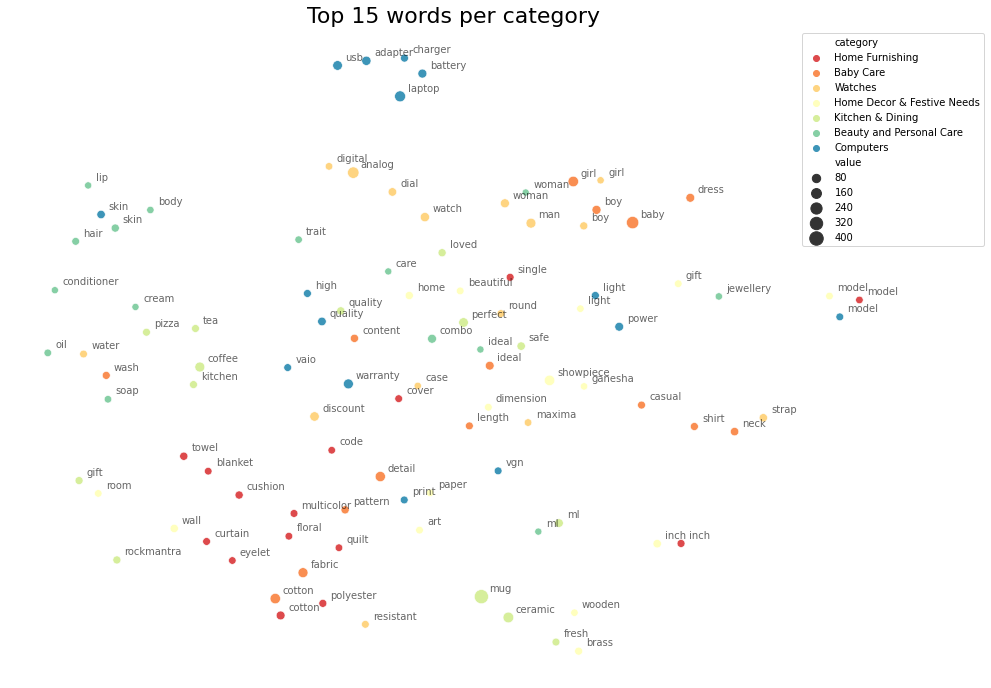

In [6]:
chart_data = pd.DataFrame(columns = ['category', 'token', 'vector'])
for category in data.category_0.unique():
    category_tokens = [element for sub in data.loc[data.category_0 == category].tokens_swa_tag for element in sub]
    most_common_tokens = Counter(category_tokens).most_common(15)
    most_common_values = [value for token, value in most_common_tokens]
    most_common_tokens = [token for token, value in most_common_tokens]
    most_common_vectors = [corpus_vectors[token] for token in most_common_tokens if token in corpus_vectors]
    
    for token, vector, value in zip(most_common_tokens, most_common_vectors, most_common_values):
        chart_data=chart_data.append({'category':category, 'token':token, 'value':value, 'vector':vector}, ignore_index=True)
    
model = TSNE(n_components=2, perplexity=10, random_state=1)
X = model.fit_transform(chart_data.vector.tolist())

chart_data['component_1'] = X[:, 0]
chart_data['component_2'] = X[:, 1]

plt.figure(figsize=(16, 12))
plt.title('Top 15 words per category', size=22)
sns.scatterplot(data=chart_data, x='component_1', y='component_2', hue='category', 
                size='value', sizes=(50, 200), palette='Spectral')
for index, row in chart_data.iterrows():
    plt.annotate(s=row['token'], 
                 xy=(row['component_1'], row['component_2']), 
                 xytext=(row['component_1']+4, row['component_2']+4), alpha=0.6)

plt.legend(bbox_to_anchor=(1.1, 1))
plt.axis('off')
plt.show()

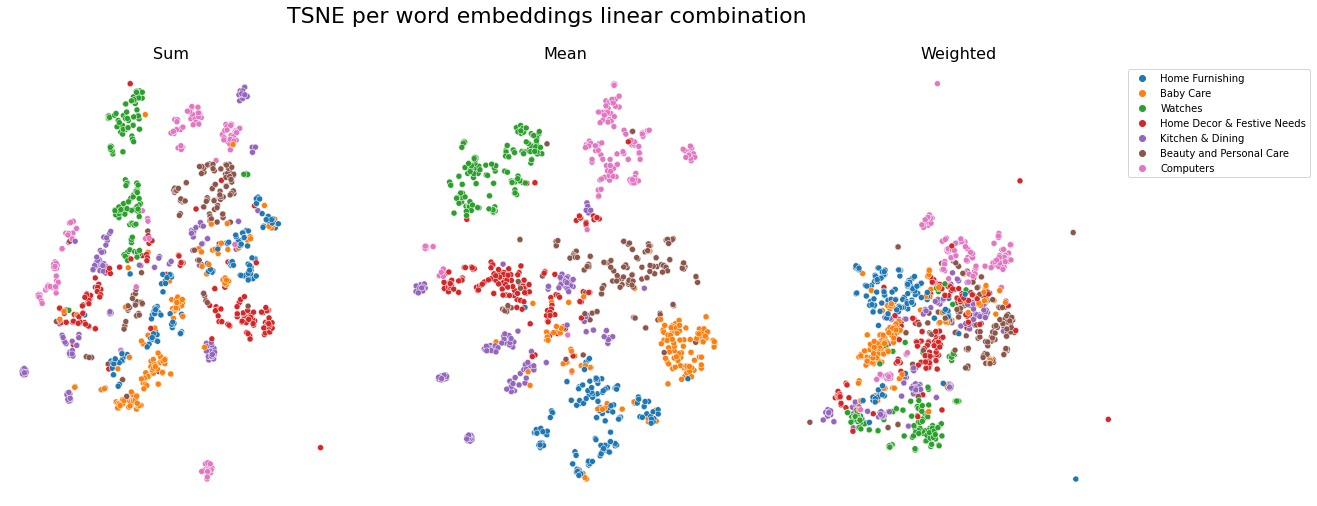

In [27]:
plt.figure(figsize=(20, 8))
plt.suptitle('TSNE per word embeddings linear combination', size=22)

for i, method in enumerate(['sum', 'mean', 'weighted']):
    
    plt.subplot(1, 3, i+1)

    text_vectors = GloveVectorizer(corpus_vectors, method=method).fit_transform(data.tokens_swa_tag)
    text_vectors.fillna(0, inplace=True)
    legend = False if i < 2 else True
    plot_TSNE(text_vectors, data.category_0, axis='off', title=method.title(), perplexity=10, legend=legend)

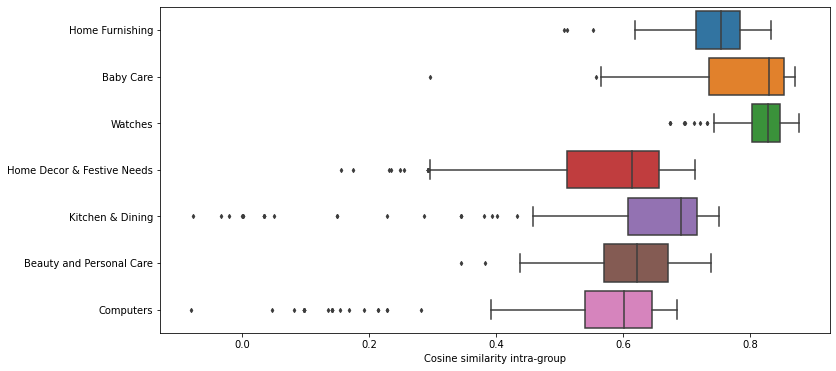

In [48]:
chart_data = pd.DataFrame()

text_vectors = GloveVectorizer(corpus_vectors, method='mean').fit_transform(data.tokens_swa_tag)
text_vectors.fillna(0, inplace=True)
text_vectors['label'] = data.category_0

for category in data.category_0.unique():
    
    vec = text_vectors.loc[text_vectors.label == category].drop(columns='label')
    m = cosine_similarity(vec)
    m = pd.DataFrame(np.apply_along_axis(lambda x: np.mean([e for e in x if e != 1]), 1, m), columns=['Cosine similarity intra-group'])
    m['Category'] = category
    chart_data = pd.concat([chart_data, m], axis=0)
    
plt.figure(figsize=(12, 6))
sns.boxplot(x = "Cosine similarity intra-group", y = "Category", data=chart_data, fliersize=3)
plt.ylabel('')
plt.show()

# Classification 

## Supervized approach

In [9]:
param_grid = {
    'column_selector__column' : preprocessing_stages,
    'vectorizer__method': ['mean', 'sum', 'weighted'],
    'PCA__ratio': [0.90, 0.95, 0.99, None]
}

pipe = Pipeline(steps=[
    ('column_selector', ColumnsSelector()),
    ('array_to_series', FunctionTransformer(lambda x: pd.Series(x))),
    ('vectorizer', GloveVectorizer(corpus_vectors)),
    ('PCA', CustomPCA()),
    ('classifier',  GaussianNB())
])

display(pipe)

Pipeline(steps=[('column_selector', ColumnsSelector()),
                ('array_to_series',
                 FunctionTransformer(func=<function <lambda> at 0x1361440d0>)),
                ('vectorizer',
                 GloveVectorizer(vectors_dict={'a': [-0.035835, 0.77844,
                                                     -0.51806, 0.080682,
                                                     -0.13173, -0.28606,
                                                     -4.2485, 0.81827, 0.24034,
                                                     -0.69057, 0.21556,
                                                     -0.12434, -0.54229,
                                                     -0.15138, -0.13591,
                                                     -0.5348, 0.34595, -0.22926,
                                                     -0.013789, 0.0...
                                                          0.37245, 0.48679,
                                                          0.75086, 0.35379, ...],
                                               'acer': [0.31683, 0.037033,
                                                        -0.32567, 0.36625,
                                                        0.88118, -0.82549,
                                                        -1.454, 0.65407,
                                                        -0.11751, -0.91607,
                                                        0.52785, 0.44302,
                                                        1.7364, 0.61005,
                                                        -0.66263, 0.18401,
                                                        -0.27329, -0.79288,
                                                        -0.7266, -0.070439,
                                                        -0.4644, -0.21659,
                                                        0.039833, 0.31058,
                                                        -0.07713, -0.26777,
                                                        -0.22538, -0.10515,
                                                        -0.3251, 0.19279, ...], ...})),
                ('PCA', CustomPCA()), ('classifier', GaussianNB())])

In [10]:
y = data.category_0

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0)

In [11]:
%%time
grid = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=2)
grid.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)

CPU times: user 4min 14s, sys: 9.11 s, total: 4min 23s
Wall time: 3min 56s


In [12]:
print('Best params: ', grid.best_params_)

Best params:  {'PCA__ratio': 0.9, 'column_selector__column': 'tokens_sw', 'vectorizer__method': 'mean'}


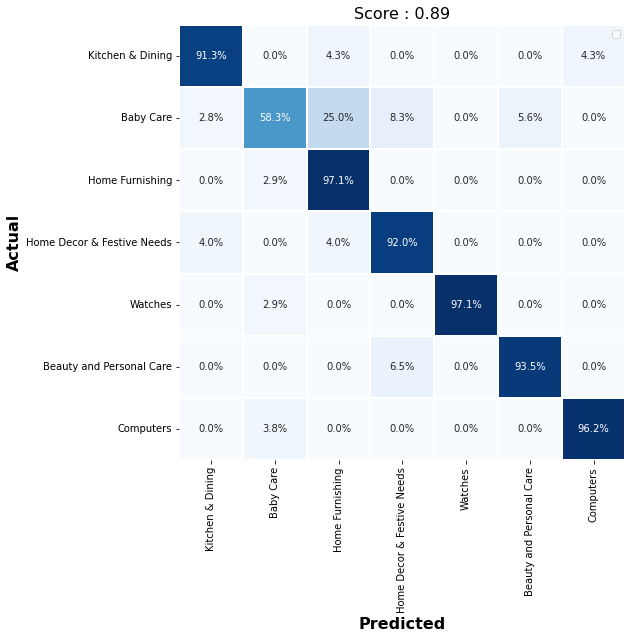

In [13]:
cm = ConfusionMatrix(y_test, y_pred, accuracy_score)
print(cm)

## Unsupervized approach

In [14]:
y = data.category_0
X = data

kmeans = KMeans(n_clusters=data.category_0.nunique(), random_state=0)

param_grid = {
    'column_selector__column' : preprocessing_stages,
    'vectorizer__method': ['mean', 'sum', 'weighted'],
    'PCA__ratio': [0.90, 0.95, 0.99, None]
}

results = pd.DataFrame()

pipe = Pipeline(steps=[
    ('column_selector', ColumnsSelector()),
    ('array_to_series', FunctionTransformer(lambda x: pd.Series(x))),
    ('vectorizer', GloveVectorizer(corpus_vectors)),
    ('PCA', CustomPCA()),
    ('clustering', CustomClustering(kmeans))
])
display(pipe)

Pipeline(steps=[('column_selector', ColumnsSelector()),
                ('array_to_series',
                 FunctionTransformer(func=<function <lambda> at 0x13671cca0>)),
                ('vectorizer',
                 GloveVectorizer(vectors_dict={'a': [-0.035835, 0.77844,
                                                     -0.51806, 0.080682,
                                                     -0.13173, -0.28606,
                                                     -4.2485, 0.81827, 0.24034,
                                                     -0.69057, 0.21556,
                                                     -0.12434, -0.54229,
                                                     -0.15138, -0.13591,
                                                     -0.5348, 0.34595, -0.22926,
                                                     -0.013789, 0.0...
                                               'acer': [0.31683, 0.037033,
                                                        -0.32567, 0.36625,
                                                        0.88118, -0.82549,
                                                        -1.454, 0.65407,
                                                        -0.11751, -0.91607,
                                                        0.52785, 0.44302,
                                                        1.7364, 0.61005,
                                                        -0.66263, 0.18401,
                                                        -0.27329, -0.79288,
                                                        -0.7266, -0.070439,
                                                        -0.4644, -0.21659,
                                                        0.039833, 0.31058,
                                                        -0.07713, -0.26777,
                                                        -0.22538, -0.10515,
                                                        -0.3251, 0.19279, ...], ...})),
                ('PCA', CustomPCA()),
                ('clustering',
                 CustomClustering(model=KMeans(n_clusters=7, random_state=0)))])

In [15]:
for parameters in tqdm(ParameterGrid(param_grid)):
    
    pipe = pipe.set_params(**parameters)
    pipe.fit(X, y)
    y_pred = pipe.predict(X)

    score = adjusted_rand_score(y, y_pred)
    results = results.append({'score': score, 'parameters': parameters} , ignore_index=True)

100%|███████████████████████████████████████████| 60/60 [02:50<00:00,  2.83s/it]


In [16]:
best_results_parameters = results.loc[results.score == results.score.max(), 'parameters'].iloc[0]
results.loc[results.score == results.score.max()]

,score,parameters
57,0.557597,"{'PCA__ratio': None, 'column_selector__column': 'tokens_swa_tag', 'vectorizer__method': 'mean'}"


In [17]:
pipe = pipe.set_params(**best_results_parameters)
pipe.fit(X, y)
y_pred = pipe.predict(X)

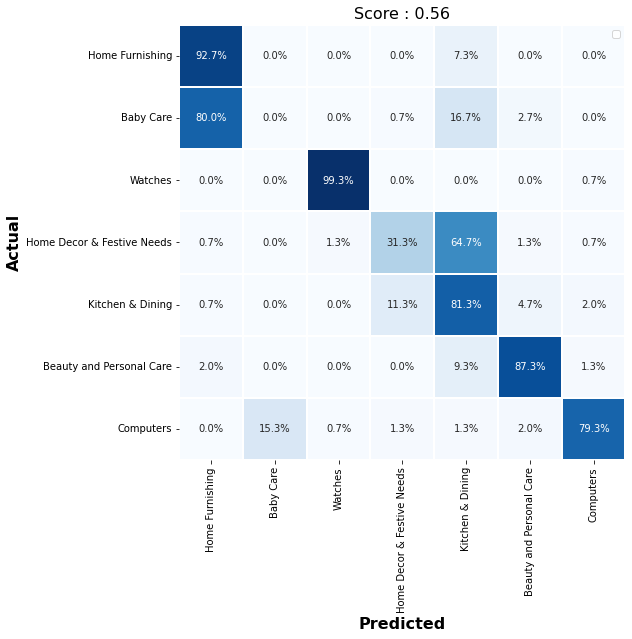

In [18]:
cm = ConfusionMatrix(y, y_pred, adjusted_rand_score)
print(cm)

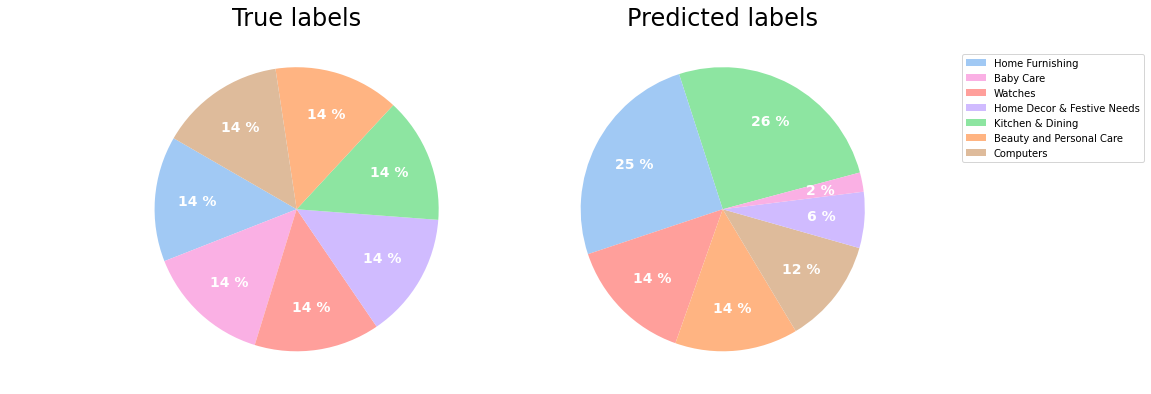

In [19]:
cd = ClusterDistribution(y, y_pred)
print(cd)